## Spacenet

Prediction using saved model


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid

In [3]:
import PIL.Image as pil_image

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from fastai.utils import *
import fastai
print(fastai.__version__)

1.0.36.dev0


In [6]:
torch.cuda.set_device(1)

#### saved model ids

model
{DATE}-{ARCH_NAME}-{MODEL_NAME}-{MODEL_DESCR}-{UID} 

data
{DATE}_{UID}_{MODEL_NAME}_export.pkl


#### 20181211-rn34-high_lr_300_unet-comboloss-stage-1-476231f5

#### 20181211-rn34-high_lr_300_unet-comboloss-unfreeze-stage-4-476231f5

#conventional model:
<pre>

0.467431 	0.424795 	0.296876 	0.953056 	0.684640

DATE: 20181211
UID: 476231f5
MODEL_NAME = 'high_lr_300_unet'
MODEL_DESCR = 'comboloss-unfreeze-stage-4'

Very poor predicted masks - mostly large white patches

</pre>

#### 20181211-rn34-300_unet-comboloss-unfreeze-1-best-ccf69ac5

#custom model

<pre>
DATE: 20181211
UID: ccf69ac5
MODEL_NAME = '300_unet'
MODEL_DESCR = 'comboloss-unfreeze-1-best'

0.552588 	0.511283 	0.357952 	0.942890 	0.640604

Really poor predictions on test set
</pre>

#### 20181211-rn34-high_lr_300_unet-comboloss-unfreeze-stage-4-476231f5

<pre>
DATE: 20181211
UID: 476231f5
MODEL_NAME = 'high_lr_300_unet'
MODEL_DESCR = 'comboloss-unfreeze-stage-4'

poor
</pre>

#### 20181211-rn34-300_unet-comboloss-unfreeze-2-best-ccf69ac5

<pre>
DATE: 20181211
UID: ccf69ac5
MODEL_NAME = '300_unet'
MODEL_DESCR = 'comboloss-unfreeze-2-best'

poor

</pre>

#### 20181211-rn34-300_unet-comboloss-unfreeze-9-epochs-ccf69ac5

<pre>
DATE: 20181211
UID: ccf69ac5
MODEL_NAME = '300_unet'
MODEL_DESCR = 'comboloss-unfreeze-9-epochs'

poor result
</pre>

#### 20181215-rn34-high_lr_300_unet-comboloss-stage-1-dd58665e

<pre>

Date 20181215
UID: dd58665e

poor
</pre>

#### 20181215-rn34-high_lr_300_unet-comboloss-stage-2-dd58665e

<pre>
to stage 2 only

DATE: 20181215
UID: dd58665e

Really poor predictions on test set
</pre>

In [7]:
DATE = '20181211'
print(f'DATE: {DATE}') 

DATE: 20181211


In [8]:
UID='476231f5'
print(f'UID: {UID}') 

UID: 476231f5


In [9]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = 'high_lr_300_unet'
MODEL_DESCR = 'comboloss-stage-1'

In [10]:
src_size=(300,300)

## Load Data

In [11]:
path = Path('../../data/SpaceNet_Off-Nadir_Dataset')
path.ls()

[PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Test'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_data'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/predicted_masks_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/training_chip_ids.npy'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/band-triplets.txt'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/SpaceNet-Off-Nadir_Sample.tar.gz'),
 PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/test_rgb'),
 

In [12]:
path_img = path/'resized_train_300'
path_lbl = path/'resized_masks_300'
path_test = path/'resized_test_300'

In [13]:
pred_masks = path/'predicted_masks_300'

In [14]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
test_fnames = get_image_files(path_test)
fnames[:3], lbl_names[:3] 

([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir19_catid_1030010003C92000_740801_3734589_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir46_catid_1030010003713C00_747551_3723339_g_6.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_748451_3727389_g_7.png')],
 [PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_734051_3741789_g_0.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_748451_3741789_g_2.png'),
  PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_741251_3742239_g_0.png')])

In [15]:
len(fnames), len(lbl_names)

(258552, 9576)

In [16]:
def get_y_fn(full_name):
    parts = str(full_name).split('_')
    im_id = '_'.join(parts[-4:])
    mask_name = 'mask_'+im_id
    return path_lbl/f'{mask_name}'

In [17]:
get_y_fn(fnames[0])

PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_masks_300/mask_740801_3734589_g_0.png')

# Make DataBunch

In [18]:
size = src_size
bs=4

In [19]:
codes = np.array(['nadir','offnadir','faroffnadir'])

In [20]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [21]:
src = (SegItemListCustom.from_folder(path_img)
        #.split_by_idx(valid_idx)
        .random_split_by_pct(0.2)
        .label_from_func(get_y_fn, classes=codes))

In [22]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [23]:
data

ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (206842 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (206842 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Valid: LabelList
y: SegLabelListCustom (51710 items)
[ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300), ImageSegment (1, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300
x: SegItemListCustom (51710 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300;

Test: None

In [24]:
data.valid_ds.items

array([PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_737201_3735039_g_1.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir32_catid_103001000392F600_738551_3731889_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir30_catid_10300100036D5200_739901_3739089_g_1.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir47_catid_10300100033C5200_744851_3736389_g_1.png'),
       ...,
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir23_catid_103001000352C200_739451_3736839_g_4.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC100_738101_3732339_g_7.png'),
       PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_train_300/Pan-Sharp

In [25]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [26]:
data.classes

array(['nadir', 'offnadir', 'faroffnadir'], dtype='<U11')

### data load

In [27]:
# DataBunch.load_empty(path) (where path points to where export.pkl file is)
export_path = path_img

In [28]:
#empty_data = data.load_empty(export_path, tfms=tfms, tfm_y=True, size=src_size).normalize(imagenet_stats)
#load specific databunch as using for training this model
empty_data = data.load_empty(path=export_path, fname=f'{DATE}_{UID}_{MODEL_NAME}_export.pkl')


# Custom Loss

In [29]:
import pdb

In [30]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [31]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [32]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [33]:
learn = unet_learner(empty_data, ARCH, metrics=metrics)

In [34]:
#best at this point in time
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-{MODEL_DESCR}-{UID}')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [35]:
test_fnames[600]

PosixPath('../../data/SpaceNet_Off-Nadir_Dataset/resized_test_300/Pan-Sharpen_Atlanta_nadir25_catid_103001000307D800_737201_3739539_g_3.png')

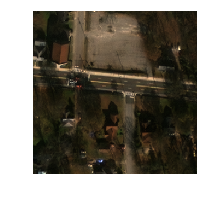

In [36]:
img = open_image(test_fnames[600])
img.show()
plt.show()

In [37]:
pred_c,pred_idx,outputs=learn.predict(img)

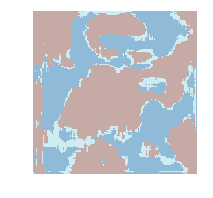

In [38]:
pred_c.show()

In [39]:
print('predicting test images')
for tn in test_fnames:
    img = open_image(tn)
    pred_c,pred_idx,outputs=learn.predict(img)
    fn = tn.name
    pred_c.save(pred_masks/f'{fn}')

predicting test images


KeyboardInterrupt: 

In [ ]:
#then run spacenet_image_format.ipynb to resize to 900x900